In [1]:
# %%

# [1] Imports and Configuration
"""
Exploratory Data Analysis (EDA) for Biomarker Discovery
=====================================================

Comprehensive EDA for CyTOF biomarker data with the following specifications:
- Target: "Response - survival" (NR=0, R=1)
- Excluded features: "Disease Group", "Therapy Subgroup", "Patient ID", "Sample ID"
- Sample filtering: Only NR and R samples included
- Features: 265 CyTOF markers
"""

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import gaussian_kde, levene, mannwhitneyu, pearsonr, shapiro, ttest_ind

# Thesis Styling Configuration
THESIS_COLORS = {
    # Primary response colors
    "responder": "#2E8B57",  # Sea Green
    "non_responder": "#DC143C",  # Crimson
    "responder_light": "#90EE90",  # Light Green
    "non_responder_light": "#FFB6C1",  # Light Pink
    # Feature selection method colors
    "statistical": "#1f77b4",  # Blue
    "mutual_info": "#ff7f0e",  # Orange
    "tree_based": "#2ca02c",  # Green
    "xgboost": "#d62728",  # Red
    "rfe": "#9467bd",  # Purple
    "regularized": "#8c564b",  # Brown
    "mrmr": "#e377c2",  # Pink
    "permutation": "#7f7f7f",  # Gray
    "all_features": "#17becf",  # Cyan
    # Classifier colors
    "logistic": "#1f77b4",  # Blue
    "random_forest": "#ff7f0e",  # Orange
    "svm": "#2ca02c",  # Green
    "xgboost_clf": "#d62728",  # Red
    "naive_bayes": "#9467bd",  # Purple
    # Threshold colors
    "threshold_40": "#1f77b4",  # Blue
    "threshold_50": "#ff7f0e",  # Orange
    "threshold_60": "#2ca02c",  # Green
    "threshold_70": "#d62728",  # Red
    "threshold_80": "#9467bd",  # Purple
    # Neutral colors
    "neutral_dark": "#2C3E50",  # Dark Blue Gray
    "neutral_medium": "#7F8C8D",  # Medium Gray
    "neutral_light": "#BDC3C7",  # Light Gray
    "white": "#FFFFFF",
    "black": "#000000",
}

# Standard plot dimensions for different plot types
THESIS_DIMENSIONS = {
    "small": {"width": 800, "height": 600},
    "medium": {"width": 1200, "height": 800},
    "large": {"width": 1600, "height": 1000},
    "extra_large": {"width": 2000, "height": 1200},
    "heatmap_standard": {"width": 1400, "height": 1000},
    "heatmap_large": {"width": 1800, "height": 1200},
    "radar_chart": {"width": 1200, "height": 1200},
    "boxplot_grid": {"width": 1600, "height": 800},
    "subplot_4col": {"width": 1600, "height": 400},
    "subplot_3col": {"width": 1200, "height": 400},
}

# Font configuration for publication quality
THESIS_FONTS = {
    "family": "Arial, sans-serif",
    "size_title": 18,
    "size_axis": 14,
    "size_legend": 12,
    "size_tick": 12,
    "size_annotation": 10,
}

# Margin configuration for legends on the right
THESIS_MARGINS = {
    "standard": {"l": 80, "r": 200, "t": 80, "b": 80},
    "large_legend": {"l": 80, "r": 250, "t": 80, "b": 80},
    "heatmap": {"l": 100, "r": 200, "t": 100, "b": 100},
    "subplot": {"l": 60, "r": 200, "t": 80, "b": 60},
}


def apply_thesis_style(fig, plot_type="standard", legend_position="right"):
    """Apply consistent thesis styling to Plotly figures."""
    # Set template and basic layout
    fig.update_layout(
        template="plotly_white",
        font=dict(family=THESIS_FONTS["family"], size=THESIS_FONTS["size_axis"]),
        title=dict(
            font=dict(size=THESIS_FONTS["size_title"]),
            x=0.5,  # Center titles
        ),
        margin=THESIS_MARGINS.get(plot_type, THESIS_MARGINS["standard"]),
    )

    # Set legend position
    if legend_position == "right":
        fig.update_layout(
            legend=dict(
                x=1.02,
                xanchor="left",
                y=1,
                yanchor="top",
                font=dict(size=THESIS_FONTS["size_legend"]),
            )
        )
    elif legend_position == "bottom":
        fig.update_layout(
            legend=dict(
                x=0.5,
                xanchor="center",
                y=-0.15,
                yanchor="top",
                orientation="h",
                font=dict(size=THESIS_FONTS["size_legend"]),
            )
        )
    elif legend_position == "top":
        fig.update_layout(
            legend=dict(
                x=0.5,
                xanchor="center",
                y=1.15,
                yanchor="bottom",
                orientation="h",
                font=dict(size=THESIS_FONTS["size_legend"]),
            )
        )
    elif legend_position == "none":
        fig.update_layout(showlegend=False)

    # Set axis styling
    fig.update_xaxes(
        tickfont=dict(size=THESIS_FONTS["size_tick"]),
        title_font=dict(size=THESIS_FONTS["size_axis"]),
    )
    fig.update_yaxes(
        tickfont=dict(size=THESIS_FONTS["size_tick"]),
        title_font=dict(size=THESIS_FONTS["size_axis"]),
    )

    # Set plot dimensions based on type
    if plot_type in THESIS_DIMENSIONS:
        dims = THESIS_DIMENSIONS[plot_type]
        fig.update_layout(width=dims["width"], height=dims["height"])

    return fig


def get_response_colors():
    """Get standardized colors for response groups."""
    return {
        "Responder (R)": THESIS_COLORS["responder"],
        "Non-Responder (NR)": THESIS_COLORS["non_responder"],
        "R": THESIS_COLORS["responder"],
        "NR": THESIS_COLORS["non_responder"],
        "Responders": THESIS_COLORS["responder"],
        "Non-Responders": THESIS_COLORS["non_responder"],
    }


# Check availability of packages for advanced clustering
try:
    import importlib.util

    seaborn_spec = importlib.util.find_spec("seaborn")
    matplotlib_spec = importlib.util.find_spec("matplotlib")
    SEABORN_AVAILABLE = seaborn_spec is not None and matplotlib_spec is not None
    if not SEABORN_AVAILABLE:
        print(
            "Warning: 'seaborn' or 'matplotlib' package not found. Advanced clustering plots will be skipped."
        )
        print("To install, run: pip install seaborn matplotlib")
except Exception:
    SEABORN_AVAILABLE = False

# PCA import removed (not used after simplifying to NR/R t-SNE and UMAP)
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Safely import UMAP and set a flag
try:
    import umap.umap_ as umap

    UMAP_AVAILABLE = True
except ImportError:
    UMAP_AVAILABLE = False
    print("Warning: 'umap-learn' package not found. UMAP plots will be skipped.")
    print("To install, run: pip install umap-learn")


# Configuration
INPUT_DATA_FILE = "lung first sample.xlsx"

In [2]:
# [Override] Enforce p<0.05 for MW plot and limit other feature plots to top 10%

import math

def _get_top_features_by_mw(X, y, feature_columns, top_fraction: float = 0.10):
    p_values = {}
    for feature in feature_columns:
        class_0 = X[y == 0][feature].dropna()
        class_1 = X[y == 1][feature].dropna()
        if not class_0.empty and not class_1.empty:
            try:
                from scipy.stats import mannwhitneyu
                _, p_val = mannwhitneyu(class_0, class_1, alternative="two-sided")
                p_values[feature] = p_val
            except Exception:
                continue
    if not p_values:
        return feature_columns
    sorted_features = sorted(p_values.items(), key=lambda kv: kv[1])
    k = max(1, math.ceil(len(feature_columns) * top_fraction))
    return [f for f, _ in sorted_features[:k]]


def create_pvalue_plot(p_values, feature_columns):
    """Create a bar plot of Mann-Whitney U test p-values (show only p < 0.05, no log scale)."""
    import pandas as pd
    import plotly.express as px

    pvalue_df = pd.DataFrame(p_values.items(), columns=["Feature", "P_Value"]).dropna()
    pvalue_df = pvalue_df[pvalue_df["P_Value"] < 0.05].sort_values("P_Value", ascending=True)

    if pvalue_df.empty:
        print("No features with p < 0.05 for Mann-Whitney U.")
        import plotly.graph_objects as go
        return go.Figure()

    fig = px.bar(
        pvalue_df,
        x="Feature",
        y="P_Value",
        title="Mann-Whitney U Test P-Values (p < 0.05)",
        color_discrete_sequence=[THESIS_COLORS["statistical"]],
    )
    return fig


def create_feature_means_plot(X, y, feature_columns):
    """Bar chart of mean difference (Responders - Non-Responders) for top 10% most significant features."""
    import numpy as np
    import pandas as pd
    import plotly.express as px

    top_features = _get_top_features_by_mw(X, y, feature_columns, top_fraction=0.10)

    rows = []
    for feature in top_features:
        vals_r = X.loc[y == 1, feature].dropna()
        vals_nr = X.loc[y == 0, feature].dropna()
        if vals_r.empty or vals_nr.empty:
            continue
        mean_r = float(np.mean(vals_r))
        mean_nr = float(np.mean(vals_nr))
        rows.append({"Feature": feature, "Mean_Diff": mean_r - mean_nr, "Mean_R": mean_r, "Mean_NR": mean_nr})

    if not rows:
        import plotly.graph_objects as go
        return go.Figure()

    df_plot = pd.DataFrame(rows).sort_values("Mean_Diff", ascending=False)
    fig = px.bar(
        df_plot,
        x="Feature",
        y="Mean_Diff",
        title="Mean Difference (R - NR) for Top 10% Features",
        color_discrete_sequence=[THESIS_COLORS["primary"]],
    )
    return fig


def create_feature_distribution_plots(X, y, feature_columns):
    """Return distribution plots (histograms) for top 10% features by Mann-Whitney p-value."""
    import plotly.express as px

    plots = {}
    top_features = _get_top_features_by_mw(X, y, feature_columns, top_fraction=0.10)

    for feature in top_features:
        df_feat = X[[feature]].copy()
        df_feat["Response"] = y.values
        df_feat = df_feat.rename(columns={feature: "Value"})

        fig = px.histogram(
            df_feat,
            x="Value",
            color="Response",
            nbins=30,
            barmode="overlay",
            title=f"Distribution of {feature} (Top 10%)",
            color_discrete_sequence=[THESIS_COLORS["negative"], THESIS_COLORS["positive"]],
        )
        plots[feature] = fig

    return plots



In [3]:
# [Override] Replace fixed top-5 selections with dynamic top 10%

import math

def _get_topk_indices(total_count: int, fraction: float = 0.10, minimum: int = 5):
    k = max(minimum, math.ceil(total_count * fraction))
    return k

# Monkey-patch helpers if needed downstream
TOP_FRACTION = 0.10
MIN_TOP_N = 5



In [4]:
# %%

# [2] Data Loading and Preprocessing
def load_and_preprocess_data(file_path):
    """Load and preprocess the biomarker data."""
    print("Loading data...")
    df = pd.read_excel(file_path)

    # Robustly detect target column
    possible_target_cols = [
        "Response - survival",
        "Response",
        "response",
        "Responder",
        "responder",
    ]
    target_column = next((c for c in possible_target_cols if c in df.columns), None)
    if target_column is None:
        matches = [c for c in df.columns if "response" in str(c).lower()]
        target_column = matches[0] if matches else None
    if target_column is None:
        raise ValueError("Could not find a target/response column in the dataset.")
    excluded_columns = [
        "Disease Group",
        "Therapy Subgroup",
        "Patient ID",
        "Sample ID",
        "Analysis run",
        "Subject"
    ]
    feature_columns = [
        col
        for col in df.columns
        if col not in excluded_columns and col != target_column
    ]

    print(f"\nTarget column: {target_column}")
    print(f"Number of feature columns: {len(feature_columns)}")
    print(f"Total initial samples: {len(df)}")

    # Filter to only include NR and R samples (or 0/1 if numeric)
    response_series = df[target_column]
    if response_series.dtype == object or response_series.dtype.name == "category":
        df_filtered = df[response_series.astype(str).isin(["NR", "R", "0", "1"])].copy()
    else:
        df_filtered = df[response_series.isin([0, 1])].copy()
    print("\n" + "=" * 60)
    print("FILTERING TO NR/R SAMPLES ONLY")
    print("=" * 60)
    print(f"Samples after filtering: {len(df_filtered)} (from {len(df)} total)")

    # Further filter to Lung only if Disease Group column exists
    if "Disease Group" in df_filtered.columns:
        lung_mask = (
            df_filtered["Disease Group"]
            .astype(str)
            .str.contains("lung", case=False, na=False)
        )
        before_count = len(df_filtered)
        df_filtered = df_filtered[lung_mask].copy()
        print("\n" + "=" * 60)
        print("FILTERING TO LUNG SAMPLES ONLY")
        print("=" * 60)
        print(
            f"Samples after lung filter: {len(df_filtered)} (from {before_count} NR/R samples)"
        )
    else:
        print("\nWarning: 'Disease Group' column not found. Lung-only filter skipped.")

    # Extract features and target
    X = df_filtered[feature_columns].copy()
    # Map response to binary 0/1 robustly
    if df_filtered[target_column].dtype == object or df_filtered[target_column].dtype.name == "category":
        y_raw = (
            df_filtered[target_column]
            .astype(str)
            .str.upper()
            .map({"NR": 0, "R": 1, "0": 0, "1": 1})
        )
    else:
        y_raw = df_filtered[target_column].astype(int)

    # Convert features to numeric, coercing errors
    print("\nConverting features to numeric...")
    for col in feature_columns:
        X[col] = pd.to_numeric(X[col], errors="coerce")

    # Handle potential missing values from coercion
    if X.isnull().sum().sum() > 0:
        print(f"Warning: {X.isnull().sum().sum()} missing values detected in features.")

    # Remove samples with missing target values and align dataframes
    valid_indices = y_raw.dropna().index
    X = X.loc[valid_indices].reset_index(drop=True)
    y = y_raw.loc[valid_indices].reset_index(drop=True)
    df_metadata = df_filtered.loc[valid_indices].reset_index(drop=True)

    print(
        f"\nFinal dataset ready for analysis: {len(y)} samples, {len(feature_columns)} features."
    )
    return X, y, feature_columns, df_metadata


# Load data
X, y, feature_columns, df_metadata = load_and_preprocess_data(INPUT_DATA_FILE)

Loading data...

Target column: Response
Number of feature columns: 166
Total initial samples: 60

FILTERING TO NR/R SAMPLES ONLY
Samples after filtering: 60 (from 60 total)


Converting features to numeric...

Final dataset ready for analysis: 60 samples, 166 features.


In [5]:
# %%

# [3] Utility Functions
def create_box_plots(X, y, feature_columns, title, y_axis_title, scaled=False):
    """Create grouped box plots for features by response status (NR/R)."""
    plot_data = X.copy()
    if scaled:
        scaler = StandardScaler()
        plot_data[feature_columns] = scaler.fit_transform(plot_data[feature_columns])

    plot_data["target_label"] = y.map({0: "Non-Responder (NR)", 1: "Responder (R)"})
    melted = plot_data.melt(
        id_vars=["target_label"],
        value_vars=feature_columns,
        var_name="Feature",
        value_name="Value",
    )

    # Use consistent response colors
    response_colors = get_response_colors()

    fig = px.box(
        melted,
        x="Feature",
        y="Value",
        color="target_label",
        points="outliers",
        title=title,
        color_discrete_map=response_colors,
        category_orders={"target_label": ["Non-Responder (NR)", "Responder (R)"]},
    )

    fig.update_layout(
        yaxis_title=y_axis_title,
        xaxis_tickangle=-45,
        boxmode="group",
        width=THESIS_DIMENSIONS["extra_large"]["width"],
        height=THESIS_DIMENSIONS["medium"]["height"],
    )

    return apply_thesis_style(fig, plot_type="extra_large")


def create_feature_means_plot(X, y, feature_columns):
    """Create bar plot of feature means by class."""
    means_by_class = X.copy()
    means_by_class["target"] = y
    means = means_by_class.groupby("target").mean().T

    # Use consistent response colors
    response_colors = get_response_colors()

    fig = go.Figure()
    for target_val in means.columns:
        class_label = "Responder (R)" if target_val == 1 else "Non-Responder (NR)"
        color = response_colors.get(class_label, THESIS_COLORS["neutral_medium"])
        fig.add_trace(
            go.Bar(
                x=means.index, y=means[target_val], name=class_label, marker_color=color
            )
        )

    fig.update_layout(
        barmode="group",
        title="Feature Means by Class",
        xaxis_title="Feature",
        yaxis_title="Mean Value",
        xaxis_tickangle=-60,
        width=THESIS_DIMENSIONS["extra_large"]["width"],
        height=THESIS_DIMENSIONS["medium"]["height"],
    )

    return apply_thesis_style(fig, plot_type="extra_large")


def create_dimensionality_reduction_plots(X, y, df_metadata):
    """Create t-SNE and UMAP visualizations for NR vs R only."""
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    plots = {}

    plot_df = pd.DataFrame(
        {
            "Response": y.map({0: "Non-Responder (NR)", 1: "Responder (R)"}),
        }
    )

    # --- t-SNE (NR vs R) ---
    print("Generating t-SNE visualization (NR vs R)...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=10)
    X_tsne = tsne.fit_transform(X_scaled)
    plot_df["TSNE1"] = X_tsne[:, 0]
    plot_df["TSNE2"] = X_tsne[:, 1]

    # Use consistent response colors
    response_colors = get_response_colors()

    plots["tsne_response"] = px.scatter(
        plot_df,
        x="TSNE1",
        y="TSNE2",
        color="Response",
        title="t-SNE of Features (NR vs R)",
        labels={"color": "Response Status"},
        color_discrete_map=response_colors,
    )
    plots["tsne_response"].update_traces(marker=dict(size=8, opacity=0.7))
    plots["tsne_response"] = apply_thesis_style(
        plots["tsne_response"], plot_type="medium"
    )

    # --- UMAP (NR vs R) ---
    if UMAP_AVAILABLE:
        print("Generating UMAP visualization (NR vs R)...")
        umap_model = umap.UMAP(n_components=2, random_state=42)
        X_umap = umap_model.fit_transform(X_scaled)
        plot_df["UMAP1"] = X_umap[:, 0]
        plot_df["UMAP2"] = X_umap[:, 1]

        plots["umap_response"] = px.scatter(
            plot_df,
            x="UMAP1",
            y="UMAP2",
            color="Response",
            title="UMAP of Features (NR vs R)",
            labels={"color": "Response Status"},
            color_discrete_map=response_colors,
        )
        plots["umap_response"].update_traces(marker=dict(size=8, opacity=0.7))
        plots["umap_response"] = apply_thesis_style(
            plots["umap_response"], plot_type="medium"
        )

    return plots


def bh_fdr(pvals):
    """Benjamini–Hochberg FDR correction (returns q-values in original order)."""
    p = np.array([1.0 if pd.isna(v) else float(v) for v in pvals], dtype=float)
    m = len(p)
    order = np.argsort(p)
    ranked = p[order]
    q = ranked * m / (np.arange(1, m + 1))
    q = np.minimum.accumulate(q[::-1])[::-1]
    out = np.empty_like(q)
    out[order.argsort()] = q
    return out


def compute_correlation_and_pvalues(X):
    """
    Compute Pearson correlation matrix and corresponding p-value matrix for DataFrame X.
    """
    cols = X.columns.tolist()
    corr_mat = X.corr(method="pearson")
    p_mat = pd.DataFrame(np.ones((len(cols), len(cols))), index=cols, columns=cols)

    for i, ci in enumerate(cols):
        for j in range(i + 1, len(cols)):
            cj = cols[j]
            a = X[ci].astype(float)
            b = X[cj].astype(float)
            mask = a.notna() & b.notna()
            if mask.sum() >= 3:
                r, p = pearsonr(a[mask], b[mask])
            else:
                r, p = (np.nan, np.nan)
            corr_mat.loc[ci, cj] = r
            corr_mat.loc[cj, ci] = r
            p_mat.loc[ci, cj] = p
            p_mat.loc[cj, ci] = p
        p_mat.loc[ci, ci] = 0.0
        corr_mat.loc[ci, ci] = 1.0
    return corr_mat, p_mat


def build_correlation_significance_table(corr_mat, p_mat, fdr_alpha=0.05):
    """
    Build a table of significantly correlated feature pairs using BH-FDR.
    Returns a DataFrame with Feature A, Feature B, r, p-value, q-value.
    """
    features = corr_mat.columns.tolist()
    m = len(features)
    pairs = []
    pvals = []
    rs = []
    idxs = []
    for i in range(m):
        for j in range(i + 1, m):
            r = corr_mat.iloc[i, j]
            p = p_mat.iloc[i, j]
            if pd.isna(p):
                continue
            pairs.append((features[i], features[j]))
            pvals.append(float(p))
            rs.append(float(r))
            idxs.append((i, j))
    if not pvals:
        return pd.DataFrame()
    # BH-FDR
    pvals_arr = np.array(pvals)
    qvals = bh_fdr(pvals_arr)

    rows = []
    for (fa, fb), r, p, qv in zip(pairs, rs, pvals_arr, qvals):
        if qv < fdr_alpha:
            rows.append(
                {
                    "Feature A": fa,
                    "Feature B": fb,
                    "Pearson r": r,
                    "P-Value": p,
                    "FDR q-value (BH)": qv,
                }
            )
    df_sig = pd.DataFrame(rows).sort_values("FDR q-value (BH)")
    return df_sig


def print_correlation_significance_table(df_sig_pairs):
    """Print FDR-significant correlated feature pairs as a formatted table."""
    if df_sig_pairs is None or df_sig_pairs.empty:
        print("No FDR-significant correlated feature pairs found.")
        return

    print("\n" + "=" * 120)
    print("FDR-SIGNIFICANT CORRELATED FEATURE PAIRS (Lung-only)")
    print("=" * 120)

    # Format the data for display
    display_df = df_sig_pairs.copy()
    display_df["Pearson r"] = display_df["Pearson r"].astype(float).round(3)
    display_df["P-Value"] = display_df["P-Value"].astype(float).round(5)
    # Format FDR q-values with scientific notation for very small values
    display_df["FDR q-value (BH)"] = display_df["FDR q-value (BH)"].astype(float)
    display_df["FDR q-value (BH)"] = display_df["FDR q-value (BH)"].apply(
        lambda x: f"{x:.2e}" if x < 0.0001 else f"{x:.4f}"
    )

    # Print header
    print(
        f"{'Feature A':<35} {'Feature B':<35} {'Pearson r':<10} {'P-Value':<10} {'FDR q-value':<12}"
    )
    print("-" * 120)

    # Print each row
    for _, row in display_df.iterrows():
        print(
            f"{row['Feature A']:<35} {row['Feature B']:<35} {row['Pearson r']:<10} {row['P-Value']:<10} {row['FDR q-value (BH)']:<12}"
        )

    print("=" * 120)
    print(f"Total FDR-significant feature pairs: {len(display_df)}")
    print("=" * 120)


def create_correlation_heatmap(corr_mat, p_mat, title="Lung-only Feature Correlations"):
    """
    Create a Plotly heatmap of correlations with significance markers.
    *: FDR q < 0.05, **: FDR q < 0.01
    """
    features = corr_mat.columns.tolist()
    m = len(features)

    # Build q-value matrix from p_mat
    q_mat = pd.DataFrame(np.ones_like(p_mat.values), index=features, columns=features)
    upper_indices = []
    p_list = []
    for i in range(m):
        for j in range(i + 1, m):
            upper_indices.append((i, j))
            p_list.append(p_mat.iloc[i, j])
    if p_list:
        q_list = bh_fdr(p_list)
        for (i, j), q in zip(upper_indices, q_list):
            q_mat.iloc[i, j] = q
            q_mat.iloc[j, i] = q
    np.fill_diagonal(q_mat.values, 0.0)

    text = []
    for i, fi in enumerate(features):
        row = []
        for j, fj in enumerate(features):
            if i == j:
                row.append("")
            else:
                q = q_mat.iloc[i, j]
                if pd.isna(q):
                    row.append("")
                elif q < 0.01:
                    row.append("**")
                elif q < 0.05:
                    row.append("*")
                else:
                    row.append("")
        text.append(row)

    fig = go.Figure(
        data=go.Heatmap(
            z=corr_mat.values,
            x=features,
            y=features,
            colorscale="RdBu",
            zmin=-1,
            zmax=1,
            colorbar=dict(title="Pearson r"),
            text=text,
            texttemplate="%{text}",
            hovertemplate="%{y} vs %{x}<br>r=%{z:.3f}<extra></extra>",
        )
    )
    fig.update_layout(
        title=title + " (FDR: * q<0.05, ** q<0.01)",
        width=THESIS_DIMENSIONS["heatmap_large"]["width"],
        height=THESIS_DIMENSIONS["heatmap_large"]["height"],
    )
    return apply_thesis_style(fig, plot_type="heatmap_large")

In [6]:
# %%

# [4] Lung-only Correlation Heatmap (All Features)
print("\n--- Correlation Heatmap (Lung-only; NR/R only) ---")
try:
    corr_mat, p_mat = compute_correlation_and_pvalues(X)
    corr_fig = create_correlation_heatmap(
        corr_mat, p_mat, title="Feature Correlation Matrix — Lung-only"
    )
    corr_fig.show()
    print("Note: FDR markers — * q<0.05; ** q<0.01 (Benjamini–Hochberg)")
except Exception as e:
    print(f"Warning: Could not generate correlation heatmap: {e}")

# Correlation significance table (FDR)
try:
    sig_corr_df = build_correlation_significance_table(corr_mat, p_mat, fdr_alpha=0.05)
    print_correlation_significance_table(sig_corr_df)
except Exception as e:
    print(f"Warning: Could not compute correlation significance table: {e}")


def compute_significance_table(X, y, feature_columns):
    """
    Compute per-feature statistics and significance between responders vs non-responders.
    Chooses t-test when normality and equal variances hold; otherwise Mann-Whitney U.
    Returns a DataFrame with means, SDs, p-values, correction, and test used.
    """
    records = []
    for feature in feature_columns:
        vals_r = X[y == 1][feature].dropna().astype(float)
        vals_nr = X[y == 0][feature].dropna().astype(float)
        if len(vals_r) < 2 or len(vals_nr) < 2:
            continue
        mean_r = float(vals_r.mean())
        sd_r = float(vals_r.std(ddof=1)) if len(vals_r) > 1 else np.nan
        mean_nr = float(vals_nr.mean())
        sd_nr = float(vals_nr.std(ddof=1)) if len(vals_nr) > 1 else np.nan

        # Normality and variance checks (robust to small samples)
        try:
            p_norm_r = shapiro(vals_r)[1] if len(vals_r) <= 5000 else 1.0
            p_norm_nr = shapiro(vals_nr)[1] if len(vals_nr) <= 5000 else 1.0
        except Exception:
            p_norm_r = p_norm_nr = 0.0
        try:
            p_var = levene(vals_r, vals_nr)[1]
        except Exception:
            p_var = 0.0

        use_ttest = p_norm_r > 0.05 and p_norm_nr > 0.05 and p_var > 0.05
        if use_ttest:
            stat, p_val = ttest_ind(vals_r, vals_nr, equal_var=True)
            test_used = "t-test"
        else:
            stat, p_val = mannwhitneyu(vals_r, vals_nr, alternative="two-sided")
            test_used = "Mann-Whitney U"

        records.append(
            {
                "Feature": feature,
                "Mean (Responders)": mean_r,
                "SD (Responders)": sd_r,
                "Mean (Non-Responders)": mean_nr,
                "SD (Non-Responders)": sd_nr,
                "P-Value": float(p_val),
                "Test Used": test_used,
            }
        )

    df_stats = pd.DataFrame.from_records(records)
    if df_stats.empty:
        return df_stats
    df_stats = df_stats.sort_values("P-Value").reset_index(drop=True)
    # Benjamini-Hochberg FDR
    pvals = df_stats["P-Value"].values.astype(float)
    qvals = bh_fdr(pvals)
    df_stats["FDR q-value (BH)"] = qvals
    return df_stats


def print_significance_table(df_stats, alpha=0.05):
    """Print features with FDR q < alpha as a formatted table."""
    if df_stats is None or df_stats.empty:
        print("No significant differences found.")
        return

    df_sig = df_stats[df_stats["FDR q-value (BH)"] < alpha].copy()
    if df_sig.empty:
        print("No features pass FDR threshold.")
        return

    print("\n" + "=" * 140)
    print("SIGNIFICANT DIFFERENCES IN IMMUNE MARKERS (Lung-only, FDR)")
    print("=" * 140)

    # Round for display
    display_df = df_sig.copy()
    for col in [
        "Mean (Responders)",
        "SD (Responders)",
        "Mean (Non-Responders)",
        "SD (Non-Responders)",
        "P-Value",
        "FDR q-value (BH)",
    ]:
        display_df[col] = display_df[col].astype(float)
    display_df["Mean (Responders)"] = display_df["Mean (Responders)"].round(3)
    display_df["SD (Responders)"] = display_df["SD (Responders)"].round(3)
    display_df["Mean (Non-Responders)"] = display_df["Mean (Non-Responders)"].round(3)
    display_df["SD (Non-Responders)"] = display_df["SD (Non-Responders)"].round(3)
    display_df["P-Value"] = display_df["P-Value"].round(5)
    # Format FDR q-values with scientific notation for very small values
    display_df["FDR q-value (BH)"] = display_df["FDR q-value (BH)"].astype(float)
    display_df["FDR q-value (BH)"] = display_df["FDR q-value (BH)"].apply(
        lambda x: f"{x:.2e}" if x < 0.0001 else f"{x:.4f}"
    )

    # Print header
    print(
        f"{'Feature':<40} {'Mean (R)':<10} {'SD (R)':<8} {'Mean (NR)':<10} {'SD (NR)':<8} {'P-Value':<10} {'FDR q-value':<12} {'Test':<15}"
    )
    print("-" * 140)

    # Print each row
    for _, row in display_df.iterrows():
        print(
            f"{row['Feature']:<40} {row['Mean (Responders)']:<10} {row['SD (Responders)']:<8} {row['Mean (Non-Responders)']:<10} {row['SD (Non-Responders)']:<8} {row['P-Value']:<10} {row['FDR q-value (BH)']:<12} {row['Test Used']:<15}"
        )

    print("=" * 140)
    print(f"Total FDR-significant features: {len(display_df)}")
    print("=" * 140)


def calculate_mann_whitney_pvalues(X, y, feature_columns):
    """Calculate Mann-Whitney U test p-values for all features."""
    p_values = {}
    for feature in feature_columns:
        class_0 = X[y == 0][feature].dropna()
        class_1 = X[y == 1][feature].dropna()
        if not class_0.empty and not class_1.empty:
            _, p_val = mannwhitneyu(class_0, class_1, alternative="two-sided")
            p_values[feature] = p_val
        else:
            p_values[feature] = np.nan
    return p_values


def create_pvalue_plot(p_values, feature_columns):
    """Create a bar plot of Mann-Whitney U test p-values (show only p < 0.05, no log scale)."""
    pvalue_df = pd.DataFrame(p_values.items(), columns=["Feature", "P_Value"]).dropna()
    # Filter to significant only and sort ascending by p-value
    pvalue_df = pvalue_df[pvalue_df["P_Value"] < 0.05].sort_values("P_Value")

    if pvalue_df.empty:
        print("No features with p < 0.05 for Mann-Whitney U.")
        return go.Figure()

    fig = px.bar(
        pvalue_df,
        x="Feature",
        y="P_Value",
        title="Mann-Whitney U Test P-Values (p < 0.05)",
        color_discrete_sequence=[THESIS_COLORS["statistical"]],
    )

    fig.add_hline(
        y=0.05,
        line_dash="dash",
        line_color=THESIS_COLORS["non_responder"],
        annotation_text="p=0.05",
    )

    fig.update_layout(
        xaxis_title="Features (p < 0.05, sorted by p-value)",
        xaxis_tickangle=-45,
        width=THESIS_DIMENSIONS["extra_large"]["width"],
        height=THESIS_DIMENSIONS["medium"]["height"],
    )

    return apply_thesis_style(fig, plot_type="extra_large")


def plot_top_feature_boxgrid(X, y, significance_df, alpha=0.05, scaled=False):
    """
    Create a grid of boxplots (NR vs R) for ALL FDR significant features
    by FDR q-value, filtered to q < alpha and ordered ascending by q.
    Uses Plotly subplots.

    Parameters:
    - X: Feature matrix
    - y: Target labels
    - significance_df: DataFrame with significance results
    - alpha: FDR threshold
    - scaled: If True, apply StandardScaler to the data
    """
    if significance_df is None or significance_df.empty:
        print("No significant features available for box grid.")
        return None

    # Keep only FDR-significant features, order ascending by q then p
    sig_only = significance_df[significance_df["FDR q-value (BH)"] < alpha].copy()
    if sig_only.empty:
        print("No features pass the FDR threshold for box grid.")
        return None
    ordered = sig_only.sort_values(["FDR q-value (BH)", "P-Value"])
    feats = ordered["Feature"].tolist()
    qvals = ordered["FDR q-value (BH)"].tolist()

    n = len(feats)
    cols = 4
    rows = int(np.ceil(n / cols))

    from plotly.subplots import make_subplots

    # Prepare data (scaled or unscaled)
    plot_data = X[feats].copy()
    if scaled:
        scaler = StandardScaler()
        plot_data = pd.DataFrame(scaler.fit_transform(plot_data), columns=feats)

    # Include q-values in subplot titles
    titles = [f"{f} (q={q:.3g})" for f, q in zip(feats, qvals)]
    fig = make_subplots(rows=rows, cols=cols, subplot_titles=titles)

    # Map y to labels
    group = y.map({0: "Non-Responders", 1: "Responders"})

    r = c = 1
    for feature in feats:
        df_plot = pd.DataFrame(
            {
                "Feature": plot_data[feature],
                "Group": group,
            }
        )
        # box traces for the two groups - use consistent colors
        response_colors = get_response_colors()
        for grp_name, color in [
            (
                "Responders",
                response_colors.get("Responder (R)", THESIS_COLORS["responder"]),
            ),
            (
                "Non-Responders",
                response_colors.get(
                    "Non-Responder (NR)", THESIS_COLORS["non_responder"]
                ),
            ),
        ]:
            vals = df_plot[df_plot["Group"] == grp_name]["Feature"]
            fig.add_trace(
                go.Box(
                    y=vals,
                    name=grp_name,
                    marker_color=color,
                    boxmean=True,
                    showlegend=False,
                ),
                row=r,
                col=c,
            )

        c += 1
        if c > cols:
            c = 1
            r += 1

    scale_text = " (Scaled)" if scaled else " (Raw)"
    fig.update_layout(
        title=f"Comparison of Immune Markers Between Responders and Non-Responders{scale_text} (All {n} FDR-significant)",
        height=max(400, rows * 300),
        width=THESIS_DIMENSIONS["boxplot_grid"]["width"],
    )

    return apply_thesis_style(fig, plot_type="boxplot_grid")


def create_variance_plot(X):
    """
    Create a bar plot with an overlayed polygon of raw feature variances.
    """
    # Calculate and sort the raw variances
    variances = X.var().sort_values(ascending=False)

    # Create the figure
    fig = go.Figure()

    # Add the bar chart
    fig.add_trace(
        go.Bar(
            x=variances.index,
            y=variances.values,
            name="Variance",
            marker_color=THESIS_COLORS["statistical"],
        )
    )

    # Add the polygon (line plot)
    fig.add_trace(
        go.Scatter(
            x=variances.index,
            y=variances.values,
            mode="lines",
            name="Variance Trend",
            line=dict(color=THESIS_COLORS["mutual_info"], width=2),
        )
    )

    # Update layout
    fig.update_layout(
        title="Feature Variances (Raw, Unscaled)",
        xaxis_title="Features (sorted by variance)",
        yaxis_title="Variance",
        xaxis_tickangle=-45,
        showlegend=False,
        width=THESIS_DIMENSIONS["extra_large"]["width"],
        height=THESIS_DIMENSIONS["medium"]["height"],
    )

    return apply_thesis_style(fig, plot_type="extra_large", legend_position="none")


def create_scaled_variance_plot(X):
    """
    Create a bar plot with an overlayed polygon of feature variances
    after StandardScaler transformation.
    """
    # Scale the data
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    # Calculate and sort the variance of each scaled feature
    scaled_variances = X_scaled.var().sort_values(ascending=False)

    # Create the figure
    fig = go.Figure()

    # Add the bar chart
    fig.add_trace(
        go.Bar(
            x=scaled_variances.index,
            y=scaled_variances.values,
            name="Variance",
            marker_color=THESIS_COLORS["statistical"],
        )
    )

    # Add the polygon (line plot)
    fig.add_trace(
        go.Scatter(
            x=scaled_variances.index,
            y=scaled_variances.values,
            mode="lines",
            name="Variance Trend",
            line=dict(color=THESIS_COLORS["mutual_info"], width=2),
        )
    )

    # Update layout
    fig.update_layout(
        title="Feature Variances After Scaling (StandardScaler)",
        xaxis_title="Features (sorted by scaled variance)",
        yaxis_title="Variance",
        xaxis_tickangle=-45,
        showlegend=False,
        width=THESIS_DIMENSIONS["extra_large"]["width"],
        height=THESIS_DIMENSIONS["medium"]["height"],
    )

    return apply_thesis_style(fig, plot_type="extra_large", legend_position="none")


def create_feature_distribution_plots(X, y, feature_columns):
    """
    Generates combined histogram and density plots for the distribution of values
    for each individual feature, grouped by response class.
    """
    plots = {}
    # Use consistent response colors
    response_colors = get_response_colors()
    color_map = {
        "Non-Responder (NR)": response_colors.get(
            "Non-Responder (NR)", THESIS_COLORS["non_responder"]
        ),
        "Responder (R)": response_colors.get(
            "Responder (R)", THESIS_COLORS["responder"]
        ),
    }

    for feature in feature_columns:
        fig = make_subplots(specs=[[{"secondary_y": True}]])
        data_nr = X[y == 0][feature].dropna()
        data_r = X[y == 1][feature].dropna()

        # Add Histograms
        fig.add_trace(
            go.Histogram(
                x=data_nr,
                name="Non-Responder (NR)",
                marker_color=color_map["Non-Responder (NR)"],
                opacity=0.6,
            ),
            secondary_y=False,
        )
        fig.add_trace(
            go.Histogram(
                x=data_r,
                name="Responder (R)",
                marker_color=color_map["Responder (R)"],
                opacity=0.6,
            ),
            secondary_y=False,
        )

        # Add Density Plots (Frequency Polygons)
        for name, data, color in [
            ("Non-Responder (NR)", data_nr, color_map["Non-Responder (NR)"]),
            ("Responder (R)", data_r, color_map["Responder (R)"]),
        ]:
            if not data.empty and len(data) > 1:  # KDE needs at least 2 points
                try:
                    kde = gaussian_kde(data)
                    x_range = np.linspace(data.min(), data.max(), 500)
                    fig.add_trace(
                        go.Scatter(
                            x=x_range,
                            y=kde(x_range),
                            mode="lines",
                            name=f"{name} Density",
                            line=dict(color=color, width=3),
                        ),
                        secondary_y=True,
                    )
                except np.linalg.LinAlgError:
                    print(
                        f"Warning: Could not compute KDE for '{feature}' for group '{name}' due to singular matrix."
                    )

        fig.update_layout(
            title_text=f"Distribution of Values for: {feature}",
            xaxis_title_text="Feature Value",
            barmode="overlay",
            legend_title_text="Response Group",
            width=THESIS_DIMENSIONS["medium"]["width"],
            height=THESIS_DIMENSIONS["medium"]["height"],
        )
        fig.update_yaxes(title_text="Count", secondary_y=False)
        fig.update_yaxes(title_text="Density", secondary_y=True)
        plots[feature] = apply_thesis_style(fig, plot_type="medium")

    return plots


--- Correlation Heatmap (Lung-only; NR/R only) ---


Note: FDR markers — * q<0.05; ** q<0.01 (Benjamini–Hochberg)

FDR-SIGNIFICANT CORRELATED FEATURE PAIRS (Lung-only)
Feature A                           Feature B                           Pearson r  P-Value    FDR q-value 
------------------------------------------------------------------------------------------------------------------------
CD3pos_total                        Tconv memCD56_Tconv                 -0.293     0.02328    0.00e+00    
Tconv memCCR4_total                 CD27IgD_Bcells                      0.167      0.20156    1.96e-89    
Tconv memCCR5_total                 PD1_CD8RO                           0.088      0.50601    1.62e-88    
Tconv naive_total                   CD4 Treg_CD4                        -0.52      2e-05      5.67e-79    
Tconv memCXCR3_total                Tconv memDR_CD3                     0.241      0.06326    6.68e-79    
Tconv memCCR4_total                 CCR4_CD8RO                          0.466      0.00017    1.23e-78    
CD8 RO PD1_CD8 

In [7]:
# %%

# [10] Hierarchical Clustering Heatmap of FDR-Significant Features
def zscore_columns(df):
    means = df.mean(axis=0)
    stds = df.std(axis=0, ddof=1).replace(0, np.nan)
    return (df - means) / stds


def plot_hierarchical_clustering(X, y, significance_df):
    """
    Plot a clustered heatmap (samples x features) for ALL FDR-significant features.
    - Select features with q < 0.05 (fallback to all features if none pass)
    - Z-score features (column-wise)
    - Perform hierarchical clustering on BOTH rows (samples) and columns (features)
    - Label rows with sample index and response (NR/R)
    """
    if significance_df is None or significance_df.empty:
        print("No significant features to cluster.")
        return None

    # Choose features
    sig = significance_df[significance_df["FDR q-value (BH)"] < 0.05][
        "Feature"
    ].tolist()
    if not sig:
        sig = significance_df.sort_values(["FDR q-value (BH)", "P-Value"])[
            "Feature"
        ].tolist()
        if not sig:
            print("No features available for clustering.")
            return None
    features = sig

    # Prepare matrix
    data = X[features].copy()
    data = zscore_columns(data).fillna(0.0)

    # Build row labels once per sample
    row_labels = [
        f"{'NR' if cls == 0 else 'R'}_{idx}" for idx, cls in enumerate(y.values)
    ]

    # Cluster columns (features) by 1 - |corr|
    try:
        from scipy.cluster.hierarchy import leaves_list, linkage
        from scipy.spatial.distance import pdist, squareform

        col_corr = np.corrcoef(data.values, rowvar=False)
        col_dist = squareform(1 - np.abs(col_corr))
        col_link = linkage(col_dist, method="average")
        col_order = leaves_list(col_link)
    except Exception:
        col_order = np.arange(data.shape[1])

    # Cluster rows (samples) by Euclidean distance in feature space
    try:
        row_dist = pdist(data.values, metric="euclidean")
        row_link = linkage(row_dist, method="average")
        row_order = leaves_list(row_link)
    except Exception:
        row_order = np.arange(data.shape[0])

    data_ordered = data.iloc[row_order, :].iloc[:, col_order]
    row_labels_ordered = [row_labels[i] for i in row_order]

    fig = go.Figure(
        data=go.Heatmap(
            z=data_ordered.values,
            x=data_ordered.columns.tolist(),
            y=row_labels_ordered,
            colorscale="RdBu",
            zmin=-2.5,
            zmax=2.5,
            colorbar=dict(title="zscore"),
            hovertemplate="Sample: %{y}<br>Feature: %{x}<br>z=%{z:.2f}<extra></extra>",
        )
    )
    fig.update_layout(
        title=f"Hierarchical Clustering of All FDR-Significant Features (n={len(features)}, Grouped by Response)",
        width=THESIS_DIMENSIONS["heatmap_large"]["width"],
        height=THESIS_DIMENSIONS["heatmap_large"]["height"],
    )

    return apply_thesis_style(fig, plot_type="heatmap_large")


def plot_hierarchical_clustering_with_groups(X, y, significance_df):
    """
    Plot a clustered heatmap with group labels for responders vs non-responders.
    Uses seaborn clustermap with proper group labeling like in the Jupyter notebook.
    """
    try:
        import matplotlib.pyplot as plt
        import seaborn as sns
        from scipy.cluster.hierarchy import linkage
        from scipy.spatial.distance import pdist
    except ImportError:
        print(
            "Warning: seaborn or matplotlib not available for advanced clustering plot."
        )
        return None

    if significance_df is None or significance_df.empty:
        print("No significant features to cluster.")
        return None

    # Choose features
    sig = significance_df[significance_df["FDR q-value (BH)"] < 0.05][
        "Feature"
    ].tolist()
    if not sig:
        sig = significance_df.sort_values(["FDR q-value (BH)", "P-Value"])[
            "Feature"
        ].tolist()
        if not sig:
            print("No features available for clustering.")
            return None
    features = sig

    # Create a DataFrame sorted by Response (0 = non-responder, 1 = responder)
    df_sorted = X[features].copy()
    df_sorted["Response"] = y
    df_sorted = df_sorted.sort_values(by="Response")

    # Extract the significant features and response labels
    X_features = df_sorted[features].T  # Transpose to have features as rows
    y_sorted = df_sorted["Response"].values  # Response variable

    # Fix normalization: Compute row-wise Z-score
    X_scaled = X_features.sub(X_features.mean(axis=1), axis=0).div(
        X_features.std(axis=1), axis=0
    )

    # Compute hierarchical clustering for features (Y-axis)
    row_linkage = linkage(pdist(X_scaled, metric="euclidean"), method="ward")

    # Create the heatmap with clustering on features
    g = sns.clustermap(
        X_scaled,
        row_cluster=True,  # Cluster rows (features)
        col_cluster=False,  # Do not cluster columns (patients)
        row_linkage=row_linkage,
        cmap="coolwarm",
        xticklabels=False,
        yticklabels=True,
        figsize=(20, 12),
        cbar_kws={"label": "Z-score"},
    )

    # Add horizontal brackets for group labels
    ax = g.ax_heatmap

    # Find x-axis index where responders start (first occurrence of 1)
    responder_start_idx = np.where(y_sorted == 1)[0][0]
    num_samples = len(y_sorted)

    # Positioning for horizontal lines
    line_ypos = -1  # Adjust as needed
    label_ypos = -1  # Adjust text label position

    # Draw horizontal lines for groups
    ax.hlines(line_ypos, 0, responder_start_idx, colors="black", linewidth=1)
    ax.hlines(line_ypos, responder_start_idx, num_samples, colors="black", linewidth=1)
    ax.vlines(0, line_ypos, line_ypos - 0.1, colors="black", linewidth=5)
    ax.vlines(
        responder_start_idx, line_ypos, line_ypos - 0.01, colors="black", linewidth=2
    )
    ax.vlines(num_samples - 1, line_ypos, line_ypos - 0.01, colors="black", linewidth=2)

    # Add group labels
    ax.text(
        responder_start_idx / 2,
        label_ypos,
        "Non-Responders",
        fontsize=14,
        ha="center",
        color="black",
    )
    ax.text(
        responder_start_idx + (num_samples - responder_start_idx) / 2,
        label_ypos,
        "Responders",
        fontsize=14,
        ha="center",
        color="black",
    )

    plt.title(
        f"Hierarchical Clustering of FDR-Significant Features (n={len(features)}) - Grouped by Response"
    )
    plt.tight_layout()
    plt.show()

    return g

In [8]:
# %%

# [4] Summary Statistics, Missing Values, and Zero Values
print("\n--- Summary Statistics for Features ---")
print(X.describe().T)

print("\n--- Missing Values Per Feature ---")
missing = X.isnull().sum()
missing = missing[missing > 0]
if not missing.empty:
    print(missing)
else:
    print("No missing values detected.")

print("\n--- Zero Values Analysis ---")
# Count zero values per feature
zero_counts = (X == 0).sum()
zero_features = zero_counts[zero_counts > 0]
if not zero_features.empty:
    print("\nFeatures with zero values (count > 0):")
    print(zero_features)

    # Find specific samples with zero values for each feature
    print("\nDetailed zero value locations (Sample ID, Feature):")
    for feature in zero_features.index:
        zero_indices = X[X[feature] == 0].index
        if len(zero_indices) > 0:
            sample_ids = df_metadata.loc[zero_indices, "Sample ID"].tolist()
            print(f"  {feature}: {len(zero_indices)} samples with zero values")
            print(f"    Sample IDs: {sample_ids}")
else:
    print("No zero values detected in any features.")


--- Summary Statistics for Features ---
                      count       mean        std        min        25%  \
CD3pos_total           60.0  40.812874  13.625193  14.365198  32.300077   
CD4 Tconv_total        60.0  27.067829  11.677950   6.664007  18.579278   
CD4 Tconv mem_total    60.0  14.751945   7.099868   4.460283   8.999932   
Tconv memCCR4_total    60.0   8.795371   4.553799   1.645645   5.598992   
Tconv memCCR5_total    60.0   1.659115   2.071293   0.089979   0.508058   
...                     ...        ...        ...        ...        ...   
CD27IgD_Bcells         60.0  15.414570  13.084943   0.556522   5.432665   
CD27negIgDneg_Bcells   60.0   6.884636   6.944528   0.618982   2.682392   
Ki67_Bcells            60.0   3.124790   2.965002   0.066568   1.395530   
memory_Bcells          60.0  23.052283  13.690751   3.189773  13.403137   
naive_Bcells           60.0  54.714997  21.199561  12.004163  40.319178   

                            50%        75%        max  
CD

In [9]:
# %%

# [5] Feature Analysis by Class
print("\n--- Generating plot of feature means by class ---")
means_plot = create_feature_means_plot(X, y, feature_columns)
means_plot.show()


--- Generating plot of feature means by class ---


In [10]:
# %%

# [6] Box Plots: Raw Features
print("\n--- Generating box plots of raw feature values (Top 10% by variance) ---")

# Select top 10% of features by variance (at least 1 feature)
_total_features = len(feature_columns)
_k_top = max(1, int(np.ceil(0.10 * _total_features)))
_top_variance_features = (
    X.var().sort_values(ascending=False).index[:_k_top].tolist()
)

raw_box_plot = create_box_plots(
    X,
    y,
    _top_variance_features,
    f"Box Plots of Raw Feature Values by Response Status — Top {_k_top} of {_total_features} by Variance",
    "Feature Value",
)
raw_box_plot.show()


--- Generating box plots of raw feature values (Top 10% by variance) ---


In [11]:
# %%

# [7] Box Plots: Scaled Features
print("\n--- Generating box plots of scaled feature values (Top 10% by variance) ---")

# Reuse the same top-variance feature set for consistency
_total_features = len(feature_columns)
_k_top = max(1, int(np.ceil(0.10 * _total_features)))
_top_variance_features = (
    X.var().sort_values(ascending=False).index[:_k_top].tolist()
)

scaled_box_plot = create_box_plots(
    X,
    y,
    _top_variance_features,
    f"Box Plots of Scaled Feature Values by Response Status — Top {_k_top} of {_total_features} by Variance",
    "Scaled Feature Value",
    scaled=True,
)
scaled_box_plot.show()


--- Generating box plots of scaled feature values (Top 10% by variance) ---


In [12]:
# %%

# [8] Dimensionality Reduction
print("\n--- Generating Dimensionality Reduction Visualizations ---")
dim_reduction_plots = create_dimensionality_reduction_plots(X, y, df_metadata)

print("\nDimensionality Reduction (NR vs R only):")

for plot_name, plot_fig in dim_reduction_plots.items():
    print(f"\nShowing {plot_name.upper()} plot...")
    plot_fig.show()


--- Generating Dimensionality Reduction Visualizations ---
Generating t-SNE visualization (NR vs R)...
Generating UMAP visualization (NR vs R)...


/home/bleacheng/Vafaee Lab Honours Work/biomarker-env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.




Dimensionality Reduction (NR vs R only):

Showing TSNE_RESPONSE plot...



Showing UMAP_RESPONSE plot...


In [13]:
# %%

# [9] Separate UMAP Visualizations
def create_separate_umap_plots(X, y, df_metadata):
    """Create separate UMAP visualizations for different grouping variables."""
    if not UMAP_AVAILABLE:
        print("UMAP not available - skipping separate UMAP plots")
        return {}

    print("Generating separate UMAP visualizations...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    plots = {}

    # UMAP for NR vs R
    print("  - UMAP for Response Status (NR vs R)...")
    umap_model = umap.UMAP(n_components=2, random_state=42)
    X_umap = umap_model.fit_transform(X_scaled)

    plot_df = pd.DataFrame(
        {
            "UMAP1": X_umap[:, 0],
            "UMAP2": X_umap[:, 1],
            "Response": y.map({0: "Non-Responder (NR)", 1: "Responder (R)"}),
        }
    )

    # Use consistent response colors
    response_colors = get_response_colors()

    plots["umap_response"] = px.scatter(
        plot_df,
        x="UMAP1",
        y="UMAP2",
        color="Response",
        title="UMAP: Response Status (NR vs R)",
        labels={"color": "Response Status"},
        color_discrete_map=response_colors,
    )
    plots["umap_response"].update_traces(marker=dict(size=8, opacity=0.7))
    plots["umap_response"] = apply_thesis_style(
        plots["umap_response"], plot_type="medium"
    )

    # UMAP for Therapy Type
    print("  - UMAP for Therapy Type...")
    if "Therapy Subgroup" in df_metadata.columns:
        therapy_plot_df = plot_df.copy()
        therapy_plot_df["Therapy_Type"] = df_metadata["Therapy Subgroup"]

        plots["umap_therapy"] = px.scatter(
            therapy_plot_df,
            x="UMAP1",
            y="UMAP2",
            color="Therapy_Type",
            title="UMAP: Therapy Type",
            labels={"color": "Therapy Type"},
        )
        plots["umap_therapy"].update_traces(marker=dict(size=8, opacity=0.7))
        plots["umap_therapy"] = apply_thesis_style(
            plots["umap_therapy"], plot_type="medium"
        )
    else:
        print("    Warning: 'Therapy Subgroup' column not found in metadata")

    # UMAP for Cancer Type (Disease Group)
    print("  - UMAP for Cancer Type...")
    if "Disease Group" in df_metadata.columns:
        cancer_plot_df = plot_df.copy()
        cancer_plot_df["Cancer_Type"] = df_metadata["Disease Group"]

        plots["umap_cancer"] = px.scatter(
            cancer_plot_df,
            x="UMAP1",
            y="UMAP2",
            color="Cancer_Type",
            title="UMAP: Cancer Type (Disease Group)",
            labels={"color": "Cancer Type"},
        )
        plots["umap_cancer"].update_traces(marker=dict(size=8, opacity=0.7))
        plots["umap_cancer"] = apply_thesis_style(
            plots["umap_cancer"], plot_type="medium"
        )
    else:
        print("    Warning: 'Disease Group' column not found in metadata")

    return plots


print("\n--- Generating Separate UMAP Visualizations ---")
separate_umap_plots = create_separate_umap_plots(X, y, df_metadata)

for plot_name, plot_fig in separate_umap_plots.items():
    print(f"\nShowing {plot_name}...")
    plot_fig.show()


--- Generating Separate UMAP Visualizations ---
Generating separate UMAP visualizations...
  - UMAP for Response Status (NR vs R)...
  - UMAP for Therapy Type...
  - UMAP for Cancer Type...

Showing umap_response...


/home/bleacheng/Vafaee Lab Honours Work/biomarker-env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [14]:
# %%

# [8.9] Show Hierarchical Clustering of FDR-Significant Features
# Moved after significance_df is computed in section [9.5]

In [15]:
# %%

# [11] Mann-Whitney U Test P-Values
print("\n--- Mann-Whitney U Test Analysis ---")
p_values = calculate_mann_whitney_pvalues(X, y, feature_columns)

significant_features = {f: p for f, p in p_values.items() if p < 0.05}

print(f"\nFeatures with p < 0.05: {len(significant_features)}")

sorted_features = []
if significant_features:
    print(f"\nAll {len(significant_features)} significant features (p < 0.05):")
    sorted_features = sorted(significant_features.items(), key=lambda item: item[1])
    for i, (feature, p_val) in enumerate(sorted_features):
        print(f"  {i + 1}. {feature}: p = {p_val:.4f}")

pvalue_plot = create_pvalue_plot(p_values, feature_columns)
pvalue_plot.show()


--- Mann-Whitney U Test Analysis ---

Features with p < 0.05: 39

All 39 significant features (p < 0.05):
  1. CD8 RO CCR5_CD3: p = 0.0002
  2. Tconv naive_total: p = 0.0003
  3. CD4 Treg_CD4: p = 0.0003
  4. Treg memory_CD4: p = 0.0006
  5. CD8pos_CD3: p = 0.0008
  6. CD4 Tconv_total: p = 0.0015
  7. Bcells CD27posIgDneg_total: p = 0.0015
  8. CD4 Tconv_CD3: p = 0.0017
  9. CD8 RO CXCR3_CD3: p = 0.0024
  10. CD27IgD_Bcells: p = 0.0026
  11. Tconv naive_CD3: p = 0.0037
  12. CD8 RO CD56_CD3: p = 0.0045
  13. CD8 RO CCR5_total: p = 0.0051
  14. CD14mono_myeloid: p = 0.0059
  15. CD16mono_myeloid: p = 0.0059
  16. CD8 RO_CD3: p = 0.0065
  17. CD8 RO CCR5_CD8: p = 0.0074
  18. CD16mono_CD3neg: p = 0.0077
  19. Treg memory_CD3: p = 0.0085
  20. Tconv memCCR5_Tconv: p = 0.0088
  21. CD4neg_CD3: p = 0.0097
  22. Tconv mem_Tconv: p = 0.0097
  23. CD8 RO DR_CD3: p = 0.0101
  24. Tconv memCXCR3_Tconv: p = 0.0101
  25. CD4 Treg _CD3: p = 0.0110
  26. Tconv naive_Tconv: p = 0.0115
  27. CD8 RA_C

In [16]:
# %%

# [12] Per-Feature Significance Table (Lung-only)
print("\n--- Computing per-feature significance table (Lung-only) ---")
significance_df = compute_significance_table(X, y, feature_columns)
if significance_df is not None and not significance_df.empty:
    print(
        f"Computed stats for {len(significance_df)} features. Showing significant ones..."
    )
    print_significance_table(significance_df, alpha=0.05)
else:
    print("No features available for significance testing.")


--- Computing per-feature significance table (Lung-only) ---
Computed stats for 166 features. Showing significant ones...

SIGNIFICANT DIFFERENCES IN IMMUNE MARKERS (Lung-only, FDR)
Feature                                  Mean (R)   SD (R)   Mean (NR)  SD (NR)  P-Value    FDR q-value  Test           
--------------------------------------------------------------------------------------------------------------------------------------------
CD8 RO CCR5_CD3                          1.803      1.586    4.363      3.798    0.00024    0.0167       Mann-Whitney U 
Tconv naive_total                        16.919     10.449   9.136      8.215    0.00025    0.0167       Mann-Whitney U 
CD4 Treg_CD4                             4.92       2.451    7.493      3.121    0.0003     0.0167       Mann-Whitney U 
Treg memory_CD4                          4.345      2.244    6.82       3.116    0.00056    0.0234       Mann-Whitney U 
CD8pos_CD3                               19.919     9.869    28.552    

In [17]:
# %%

# [13] Hierarchical Clustering Heatmap of FDR-Significant Features
print("\n--- Generating Hierarchical Clustering Heatmap (Plotly version) ---")
try:
    hc_fig = plot_hierarchical_clustering(X, y, significance_df)
    if hc_fig is not None:
        hc_fig.show()
except Exception as e:
    print(f"Warning: Could not render hierarchical clustering heatmap (Plotly): {e}")


--- Generating Hierarchical Clustering Heatmap (Plotly version) ---



--- Generating Advanced Hierarchical Clustering with Group Labels (Seaborn version) ---


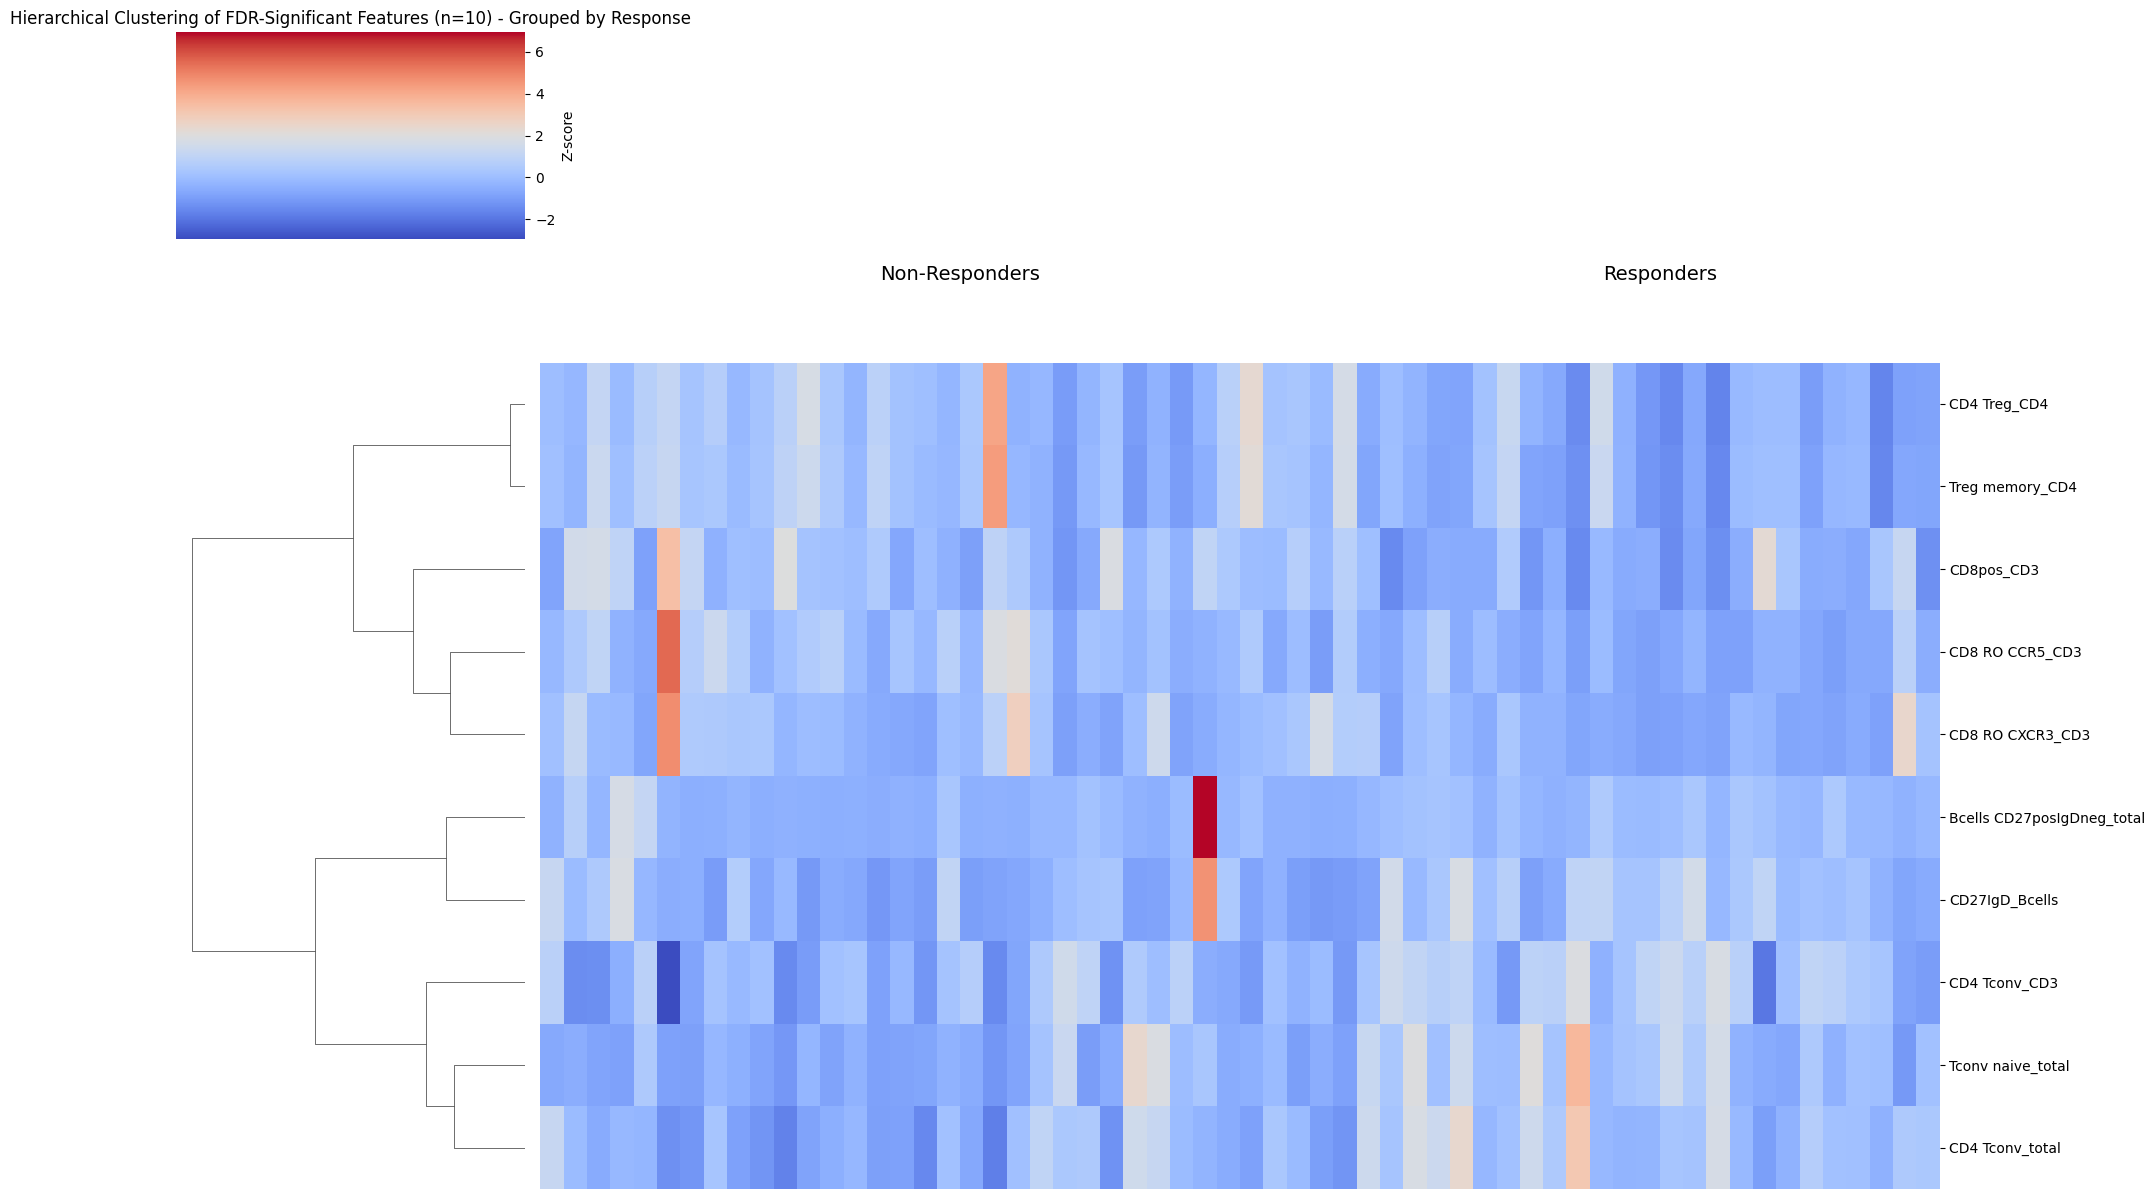

Advanced hierarchical clustering heatmap with group labels displayed successfully.


In [18]:
# %%

# [13.5] Advanced Hierarchical Clustering with Group Labels (Seaborn version)
print(
    "\n--- Generating Advanced Hierarchical Clustering with Group Labels (Seaborn version) ---"
)
if SEABORN_AVAILABLE:
    try:
        hc_groups_fig = plot_hierarchical_clustering_with_groups(X, y, significance_df)
        if hc_groups_fig is not None:
            print(
                "Advanced hierarchical clustering heatmap with group labels displayed successfully."
            )
    except Exception as e:
        print(
            f"Warning: Could not render advanced hierarchical clustering heatmap: {e}"
        )
else:
    print("Skipping advanced clustering plot - seaborn/matplotlib not available.")

In [19]:
# %%

# [14] Feature Variance Analysis (Unscaled)
print("\n--- Feature Variance Analysis (Unscaled) ---")
variances = X.var().sort_values(ascending=False)

print("\nTop 5 highest variance features:")
print(variances.head(5).round(4))
print("\nTop 5 lowest variance features:")
print(variances.tail(5).round(4))

variance_plot = create_variance_plot(X)
variance_plot.show()


--- Feature Variance Analysis (Unscaled) ---

Top 5 highest variance features:
CD4neg_CD3           1114.0078
naive_Bcells          449.4214
Tconv mem_Tconv       411.9266
Tconv naive_Tconv     408.0797
myeloid_CD3neg        392.5248
dtype: float64

Top 5 lowest variance features:
Treg naive_CD3         0.0939
Bcells Ki67_CD3neg     0.0925
Tconv memCD56_total    0.0639
Treg naive_total       0.0267
Bcells Ki67_total      0.0190
dtype: float64


In [20]:
# %%

# [15] Scaled Feature Variance Analysis
print("\n--- Feature Variance Analysis (After Scaling) ---")
scaled_variance_plot = create_scaled_variance_plot(X)
scaled_variance_plot.show()


--- Feature Variance Analysis (After Scaling) ---


In [21]:
# %%

# [16] Feature-wise Value Distribution
print("\n--- Generating Feature-wise Distribution Plots ---")
# Note: This generates a plot for every feature. We will only display the most significant ones.
feature_dist_plots = create_feature_distribution_plots(X, y, feature_columns)

# Get the top 5 most significant features from the Mann-Whitney test in section [9]
if sorted_features:
    top_features = [f for f, p in sorted_features[:5]]
    print("\nDisplaying distribution plots for the top 5 most significant features:")
    for feature_name in top_features:
        print(f"  - Showing plot for: {feature_name}")
        feature_dist_plots[feature_name].show()
else:
    print(
        "\nNo statistically significant features found. Showing plots for the first 5 features as an example:"
    )
    for i, (feature_name, fig) in enumerate(feature_dist_plots.items()):
        if i >= 5:
            break
        print(f"  - Showing plot for: {feature_name}")
        fig.show()


print("\nEDA complete.")


--- Generating Feature-wise Distribution Plots ---

Displaying distribution plots for the top 5 most significant features:
  - Showing plot for: CD8 RO CCR5_CD3


  - Showing plot for: Tconv naive_total


  - Showing plot for: CD4 Treg_CD4


  - Showing plot for: Treg memory_CD4


  - Showing plot for: CD8pos_CD3



EDA complete.


In [22]:
# %%

# [17] Small Multiples: All FDR-Significant Features (Boxplots NR vs R) - Raw Data
print("\n--- Generating FDR-Significant Feature Boxplots (Raw Data) ---")
try:
    raw_box_fig = plot_top_feature_boxgrid(X, y, significance_df, scaled=False)
    if raw_box_fig is not None:
        raw_box_fig.show()
except Exception as e:
    print(f"Warning: Could not render FDR-significant boxplot grid (raw): {e}")


--- Generating FDR-Significant Feature Boxplots (Raw Data) ---


In [23]:
# %%

# [18] Small Multiples: All FDR-Significant Features (Boxplots NR vs R) - Scaled Data
print("\n--- Generating FDR-Significant Feature Boxplots (Scaled Data) ---")
try:
    scaled_box_fig = plot_top_feature_boxgrid(X, y, significance_df, scaled=True)
    if scaled_box_fig is not None:
        scaled_box_fig.show()
except Exception as e:
    print(f"Warning: Could not render FDR-significant boxplot grid (scaled): {e}")

print("\nEDA complete.")


--- Generating FDR-Significant Feature Boxplots (Scaled Data) ---



EDA complete.
